In [1]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, StandardScaler
plt.style.use('seaborn-whitegrid')

# PSS Score

In [2]:
def get_threshold(scores):
    scores = np.array(scores)
    lower_threshold = scores.mean() - (scores.std()/2)
    upper_threshold = scores.mean() + (scores.std()/2)
    return scores.mean(), (lower_threshold,upper_threshold)

def get_stress_type(score, grade):
    """ Non-stress (0): score < lower_threshold
        Neutral    (1): lower_threshold <= score <= upper_threshold
        Stress     (2): score > lower_threshold """
    if(score < grade[0]):
        return 0
    elif(score <= grade[1]):
        return 1
    elif(score > grade[1]):
        return 2

def PSS_printer(PSS):
    # peak at info
    temp = PSS.popitem()
    PSS[temp[0]] = temp[1]
    column = list(temp[1].keys())
    space = "\t\t"
    print(f"Name{space}",f"{space}".join(column),sep="" )
    print("="*60)
    for name, info in PSS.items():
        print(f"{name}{space}",sep="",end="")
        for col in column:
            print(f"{info[col]}{space}",end="")

        print()


TYPE_DEF = {0:'Non-Stress', 1:'Neutral', 2: 'Stress'}

In [3]:
PSS = dict()
scores = []
with open('./PSS_scores.csv','r') as f:
    f.readline() # skip header
    for line in f.readlines(): 
        name,score = line.split(',')
        PSS[name] = {'score':int(score)}
        scores.append(int(score))

mean, grade = get_threshold(scores)
print(f"Total={len(PSS)} | Mean={mean} | Lower Thres={grade[0]} | Higher Thres={grade[1]}")

type_count = {0:0, 1:0, 2:0}
for name, dict_info in PSS.items():
    label = get_stress_type(dict_info['score'], grade)
    dict_info['type'] = label
    dict_info['type_definition'] = TYPE_DEF[label]
    type_count[label] = type_count[label] + 1

print(f"Non Stress={type_count[0]} | Neutral={type_count[1]} | Stress={type_count[2]}")

PSS_printer(PSS)

Total=55 | Mean=20.509090909090908 | Lower Thres=17.43445460055748 | Higher Thres=23.583727217624336
Non Stress=16 | Neutral=20 | Stress=19
Name		score		type		type_definition
fabby		25		2		Stress		
bas		25		2		Stress		
flm		37		2		Stress		
mind		22		1		Neutral		
taew		21		1		Neutral		
MJ		12		0		Non-Stress		
nopphon		22		1		Neutral		
boss		22		1		Neutral		
film		18		1		Neutral		
new		28		2		Stress		
nice		18		1		Neutral		
nuclear		15		0		Non-Stress		
pang		29		2		Stress		
prin		9		0		Non-Stress		
amp		13		0		Non-Stress		
beau		9		0		Non-Stress		
dt		16		0		Non-Stress		
int		15		0		Non-Stress		
minkhant		24		2		Stress		
sam		18		1		Neutral		
yong		27		2		Stress		
aui		28		2		Stress		
bank		25		2		Stress		
dream		19		1		Neutral		
eiyu		24		2		Stress		
ice		22		1		Neutral		
job		13		0		Non-Stress		
kee		25		2		Stress		
miiw		14		0		Non-Stress		
noey		8		0		Non-Stress		
pear		23		1		Neutral		
por		22		1		Neutral		
satya		18		1		Neutral		
shin		13		0		Non-Stress		
suyo		17		0		Non-Stress		


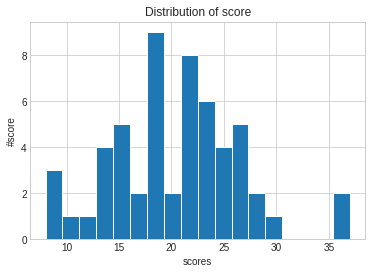

findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


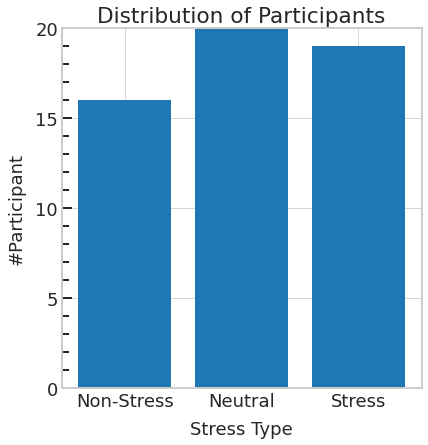

In [4]:
######## Plot Distribution of score
binwidth = 10
# Draw the plot
plt.hist(scores, bins = int(180/binwidth), edgecolor = 'white')

# Title and labels
plt.title('Distribution of score')
plt.xlabel('scores')
plt.ylabel('#score')
plt.show()

######## Plot Distribution of Labels
import matplotlib as mpl
from pylab import cm
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
# Generate 2 colors from the 'tab10' colormap
colors = cm.get_cmap('tab10', 2)

fig, ax = plt.subplots(figsize=(5,5))
ax = fig.add_axes([0, 0, 1, 1])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in',)# top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in',)# top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')#, right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in')#, right='on')


ax.bar([TYPE_DEF[0],TYPE_DEF[1],TYPE_DEF[2]],[ type_count[0], type_count[1], type_count[2] ], color=colors(0))

# Set the axis limits
# ax.set_xlim(0,10)
ax.set_ylim(0, 20)
# ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.set_title("Distribution of Participants")
ax.set_xlabel('Stress Type', labelpad=10)
ax.set_ylabel('#Participant', labelpad=10)
plt.show()

# Load EEG data

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5722792/

The frontal asymmetry is most commonly computed by subtracting the natural log of left hemisphere alpha power (EEG electrode F3) from the natural log of right hemisphere alpha power (F4) while using the central Cz as reference electrode

In [5]:
sampling_rate = 125 #Hz
files = glob(f"data/*.csv")
for index, f in enumerate(files):
    name = f.split('/')[1].split('__')[0]
    pd_raw = pd.read_csv(f, dtype={'Marker':str})
    pd_raw = pd_raw.drop(columns='timestamps')
    raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
    PSS[name]['raw'] = raw
    print(f"{index} {name} | time: {len(pd_raw)/125}")


0 suyo | time: 610.56
1 poon | time: 632.64
2 minkhant | time: 609.312
3 ice | time: 612.864
4 MJ | time: 476.544
5 s | time: 608.16
6 harold | time: 609.312
7 dt | time: 611.424
8 beau | time: 612.768
9 satya | time: 611.52
10 prin | time: 610.752
11 pang | time: 609.504
12 ploy | time: 608.544
13 eiyu | time: 613.056
14 bas | time: 608.832
15 mu | time: 609.216
16 film | time: 606.912
17 aui | time: 611.904
18 cedric | time: 607.2
19 nice | time: 611.136
20 yee | time: 623.808
21 bank | time: 609.696
22 gon | time: 614.592
23 bas | time: 608.832
24 flm | time: 602.688
25 dream | time: 612.0
26 pla | time: 610.656
27 bam | time: 355.52
28 amp | time: 612.288
29 tom | time: 612.768
30 job | time: 609.888
31 nuclear | time: 611.04
32 noey | time: 612.864
33 beer | time: 619.008
34 mind | time: 613.056
35 sam | time: 609.792
36 por | time: 612.0
37 nopphon | time: 615.744
38 pear | time: 630.816
39 shin | time: 611.712
40 younten | time: 612.192
41 taew | time: 641.952
42 nisit | time: 6

fabby
    Using multitaper spectrum estimation with 7 DPSS windows


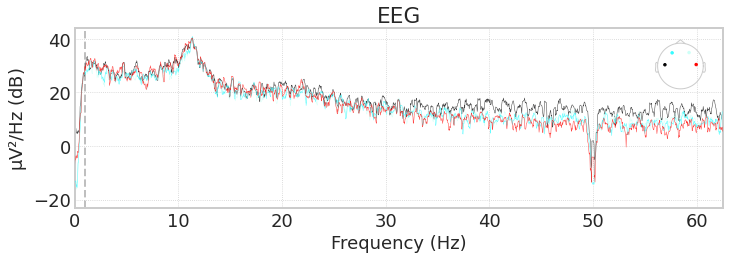

bas
    Using multitaper spectrum estimation with 7 DPSS windows


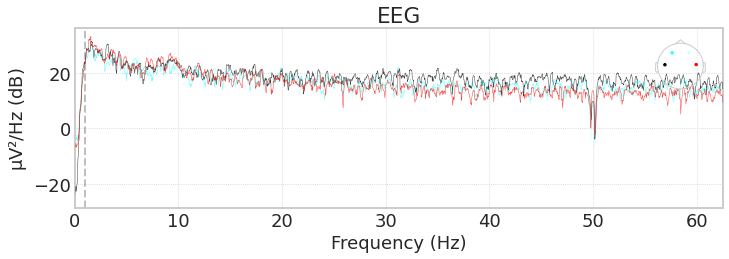

flm
    Using multitaper spectrum estimation with 7 DPSS windows


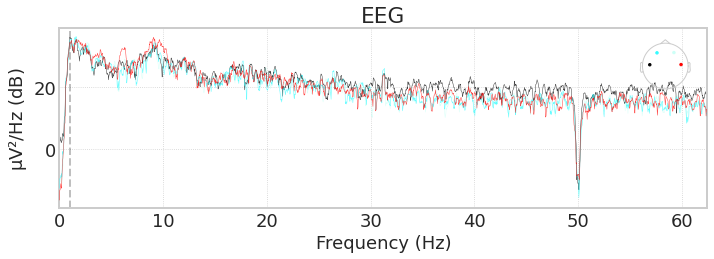

mind
    Using multitaper spectrum estimation with 7 DPSS windows


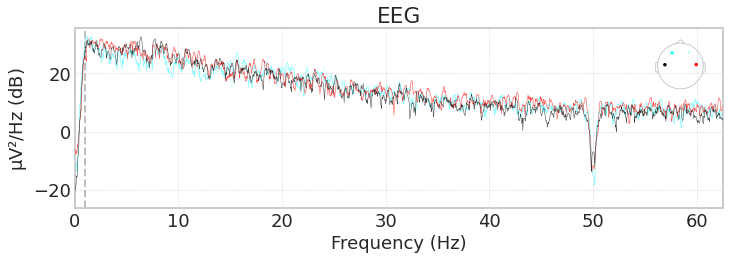

taew
    Using multitaper spectrum estimation with 7 DPSS windows


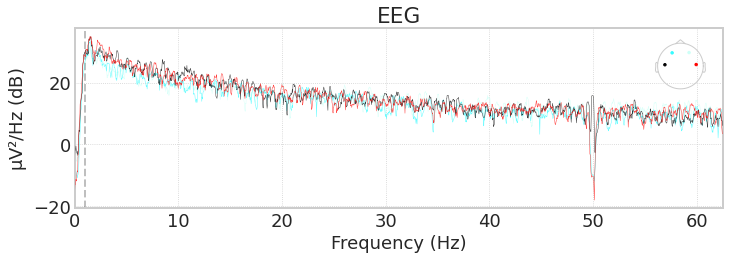

MJ
    Using multitaper spectrum estimation with 7 DPSS windows


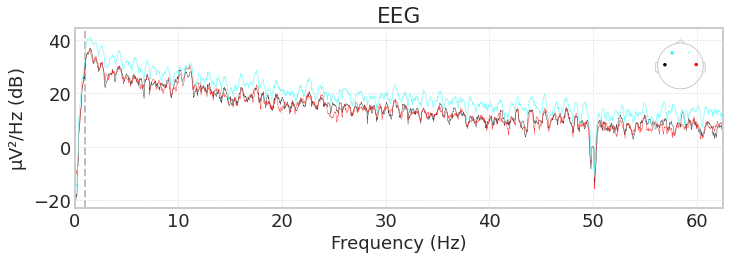

nopphon
    Using multitaper spectrum estimation with 7 DPSS windows


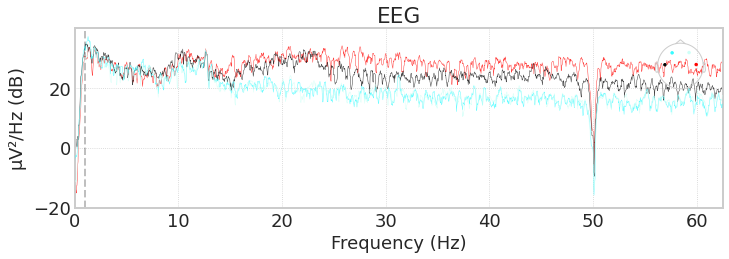

boss
    Using multitaper spectrum estimation with 7 DPSS windows


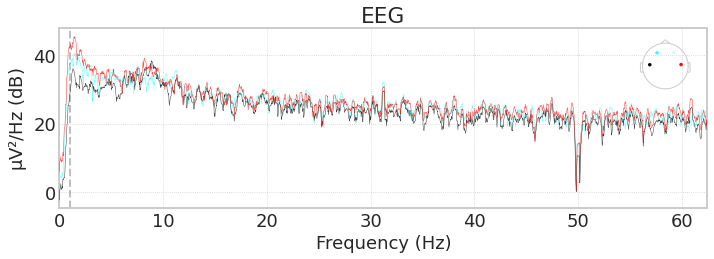

film
    Using multitaper spectrum estimation with 7 DPSS windows


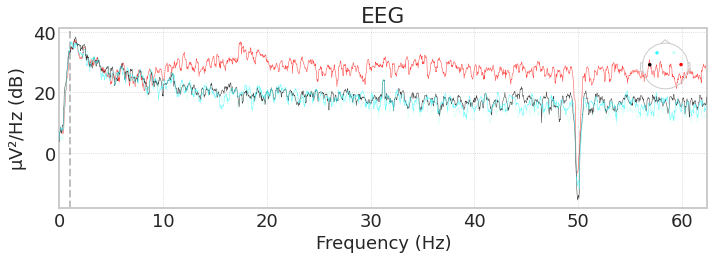

new
    Using multitaper spectrum estimation with 7 DPSS windows


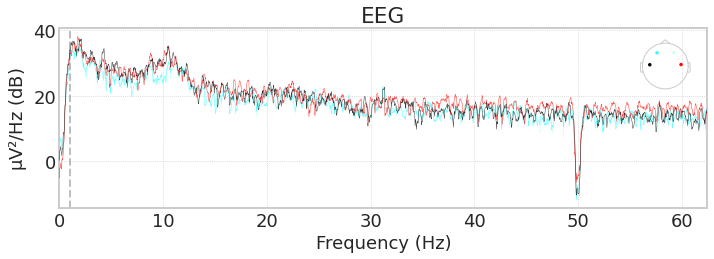

nice
    Using multitaper spectrum estimation with 7 DPSS windows


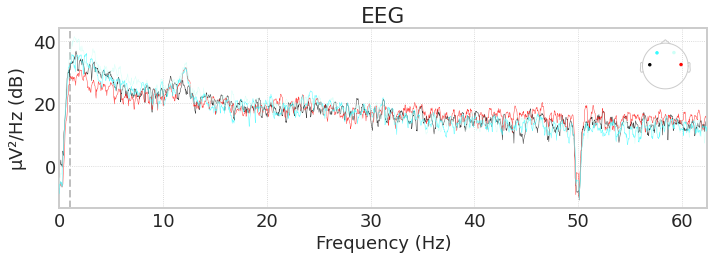

nuclear
    Using multitaper spectrum estimation with 7 DPSS windows


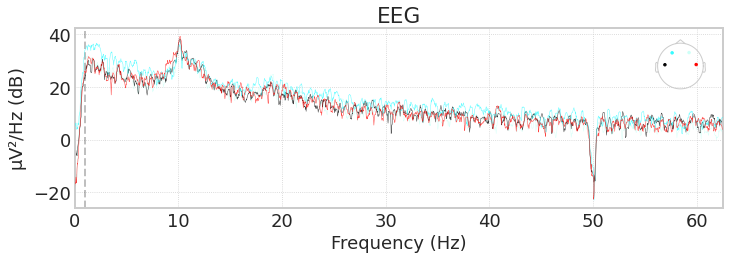

pang
    Using multitaper spectrum estimation with 7 DPSS windows


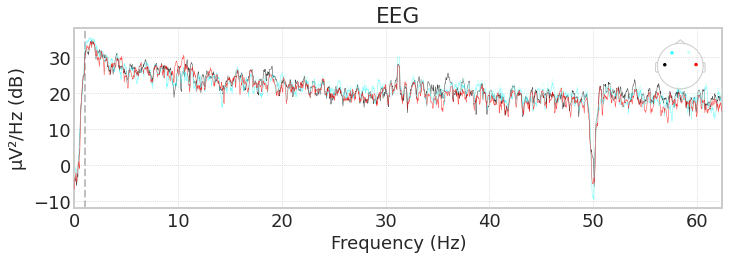

prin
    Using multitaper spectrum estimation with 7 DPSS windows


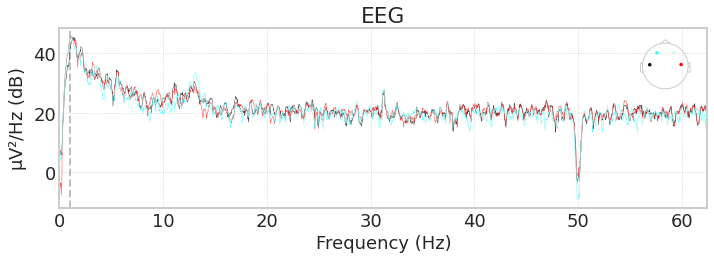

amp
    Using multitaper spectrum estimation with 7 DPSS windows


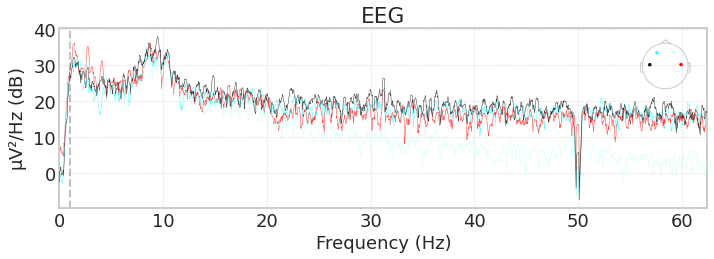

beau
    Using multitaper spectrum estimation with 7 DPSS windows


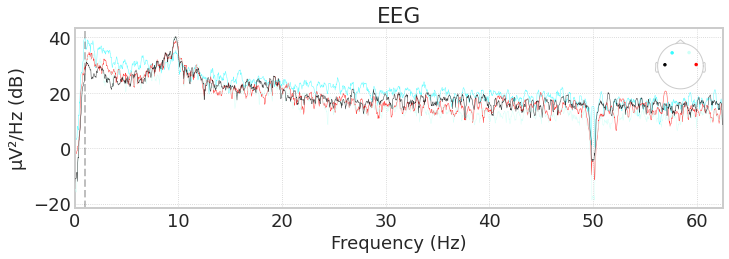

dt
    Using multitaper spectrum estimation with 7 DPSS windows


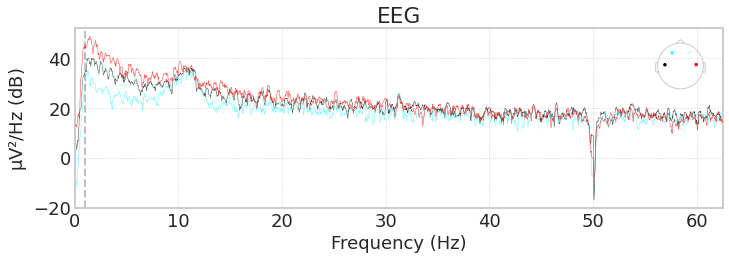

int
    Using multitaper spectrum estimation with 7 DPSS windows


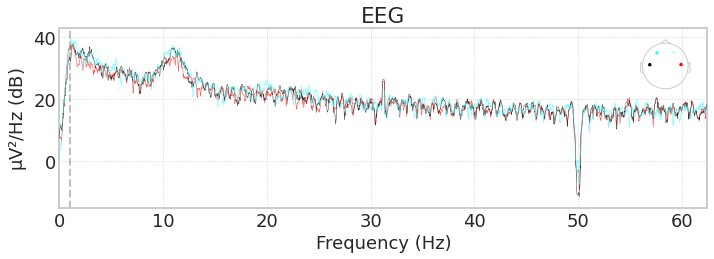

minkhant
    Using multitaper spectrum estimation with 7 DPSS windows


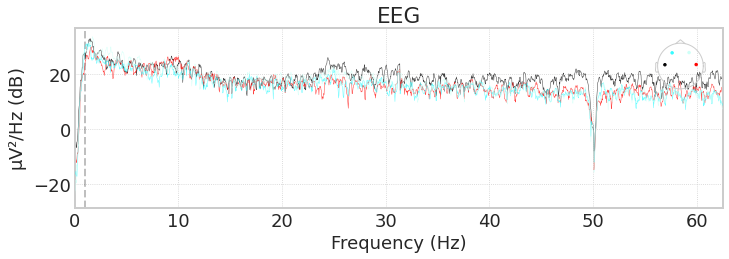

sam
    Using multitaper spectrum estimation with 7 DPSS windows


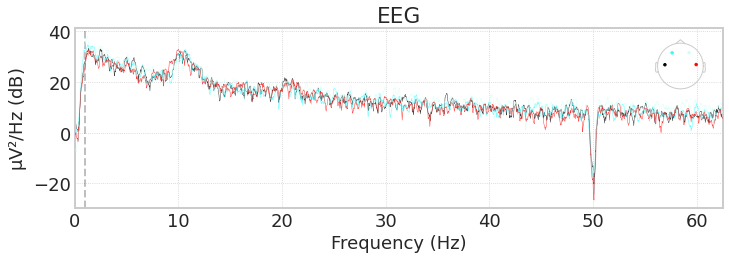

yong
    Using multitaper spectrum estimation with 7 DPSS windows


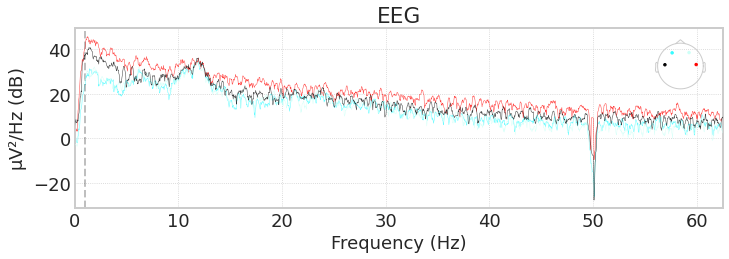

aui
    Using multitaper spectrum estimation with 7 DPSS windows


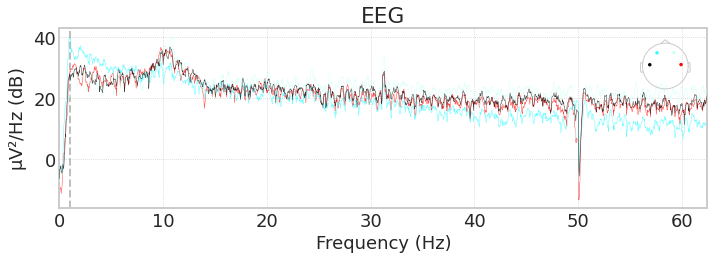

bank
    Using multitaper spectrum estimation with 7 DPSS windows


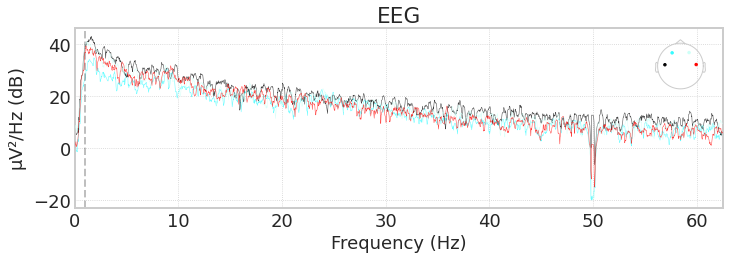

dream
    Using multitaper spectrum estimation with 7 DPSS windows


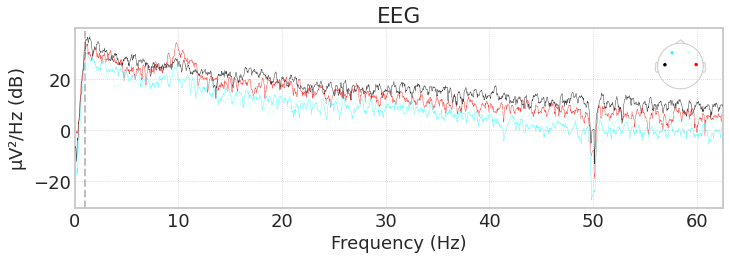

eiyu
    Using multitaper spectrum estimation with 7 DPSS windows


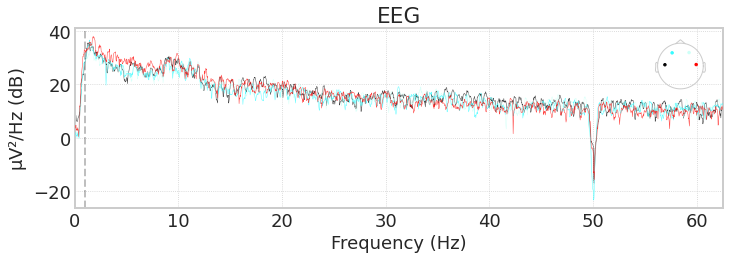

ice
    Using multitaper spectrum estimation with 7 DPSS windows


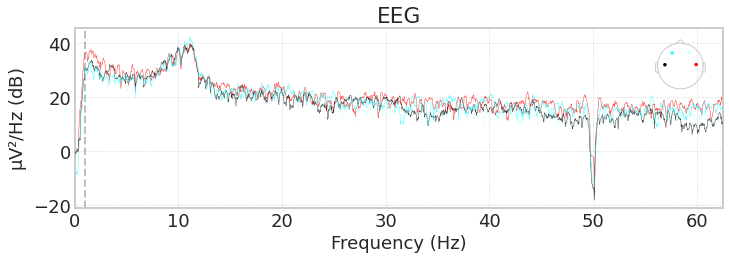

job
    Using multitaper spectrum estimation with 7 DPSS windows


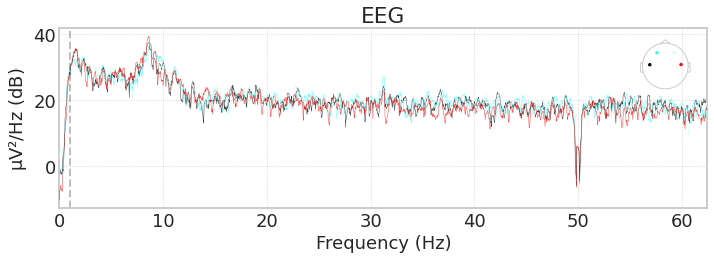

kee
    Using multitaper spectrum estimation with 7 DPSS windows


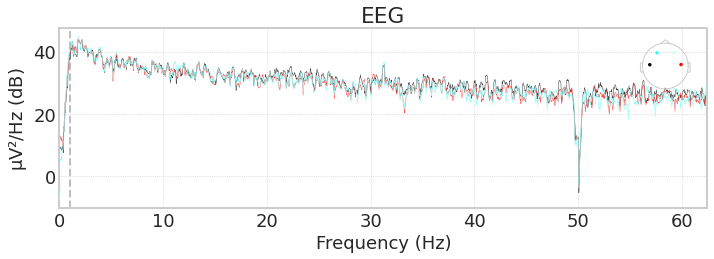

miiw
    Using multitaper spectrum estimation with 7 DPSS windows


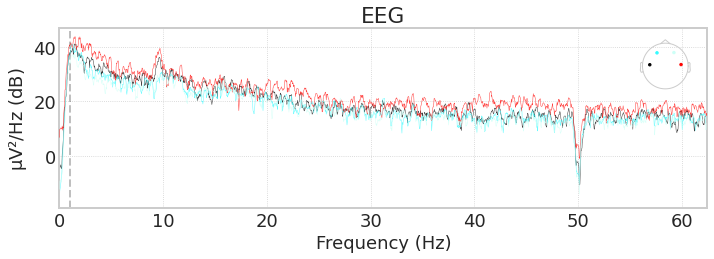

noey
    Using multitaper spectrum estimation with 7 DPSS windows


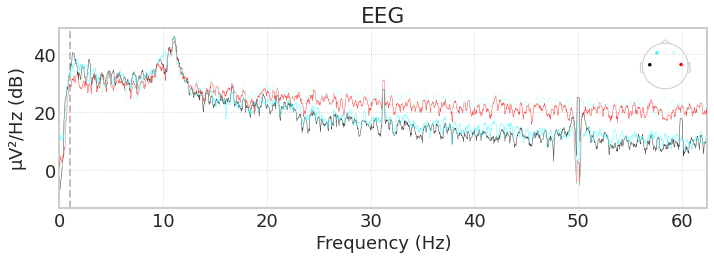

pear
    Using multitaper spectrum estimation with 7 DPSS windows


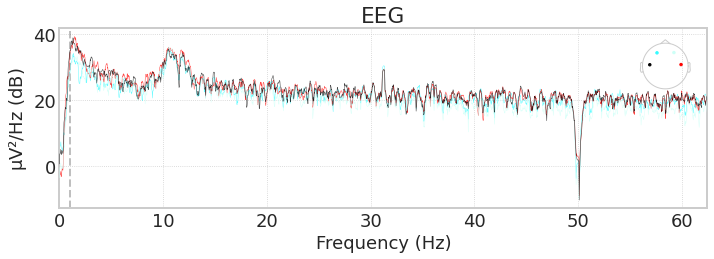

por
    Using multitaper spectrum estimation with 7 DPSS windows


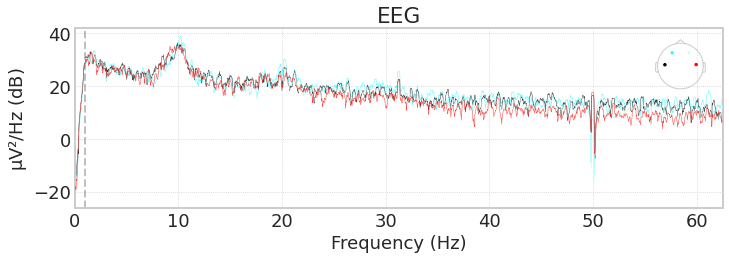

satya
    Using multitaper spectrum estimation with 7 DPSS windows


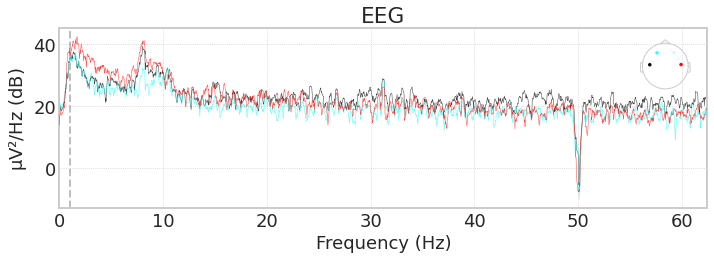

shin
    Using multitaper spectrum estimation with 7 DPSS windows


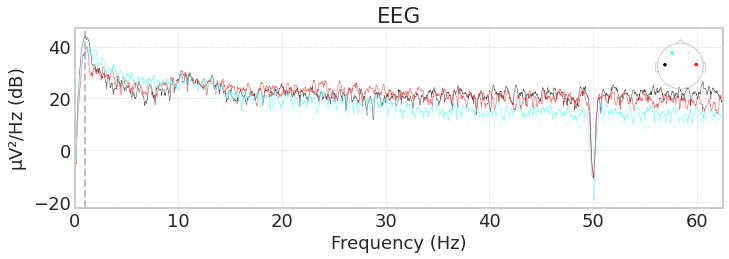

suyo
    Using multitaper spectrum estimation with 7 DPSS windows


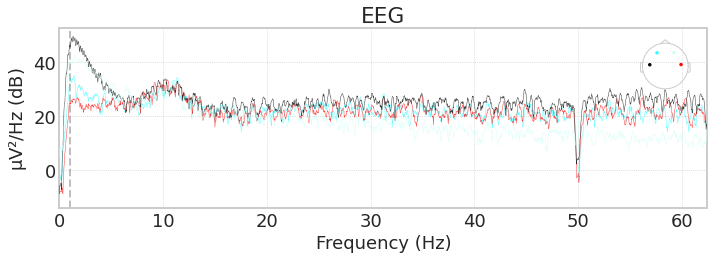

tom
    Using multitaper spectrum estimation with 7 DPSS windows


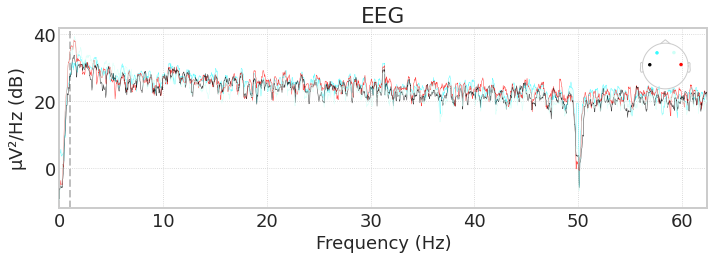

yee
    Using multitaper spectrum estimation with 7 DPSS windows


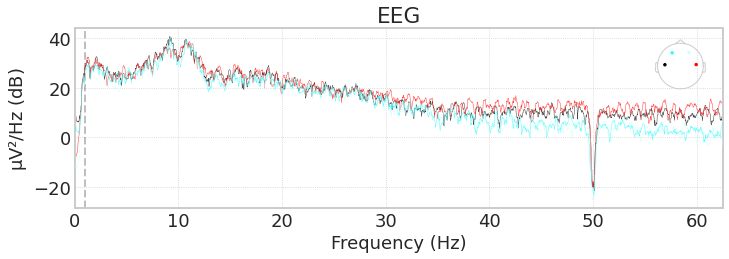

aun
    Using multitaper spectrum estimation with 7 DPSS windows


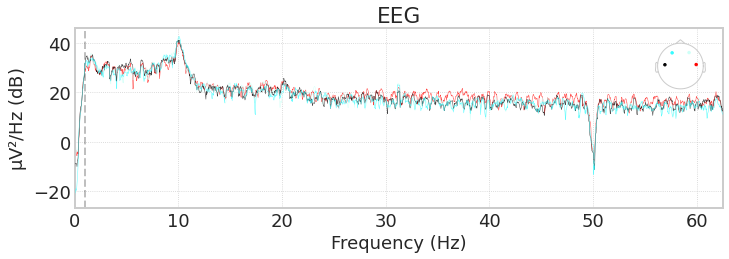

bam
    Using multitaper spectrum estimation with 7 DPSS windows


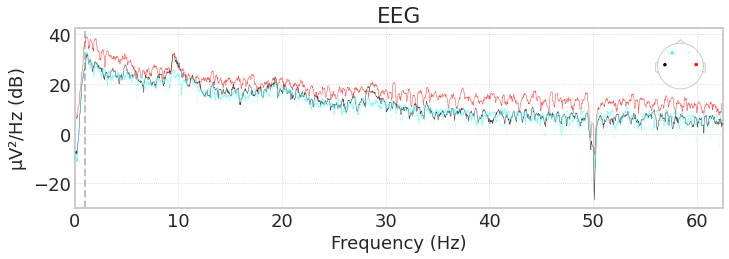

beer
    Using multitaper spectrum estimation with 7 DPSS windows


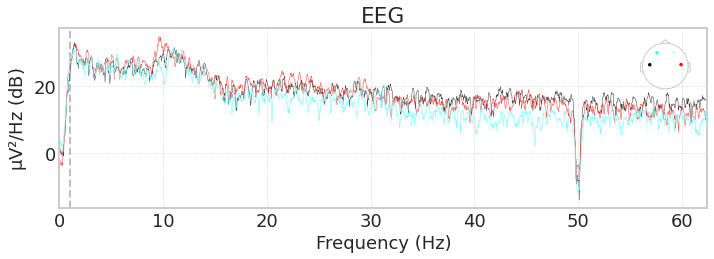

cedric
    Using multitaper spectrum estimation with 7 DPSS windows


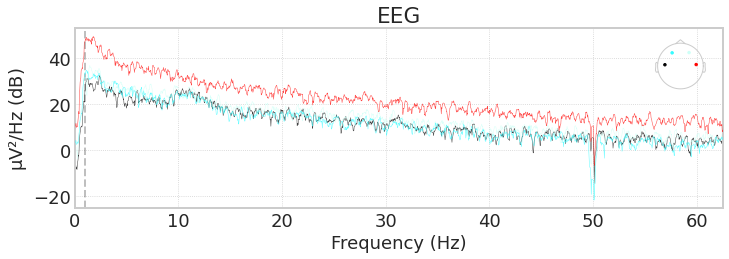

fahmai
    Using multitaper spectrum estimation with 7 DPSS windows


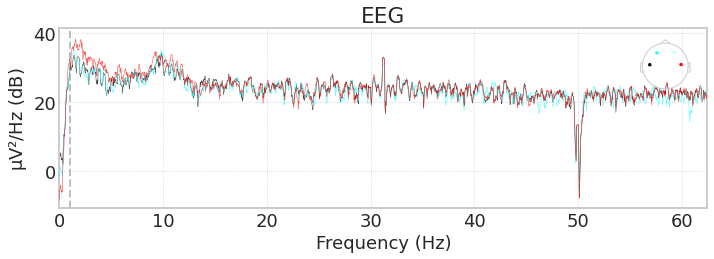

gon
    Using multitaper spectrum estimation with 7 DPSS windows


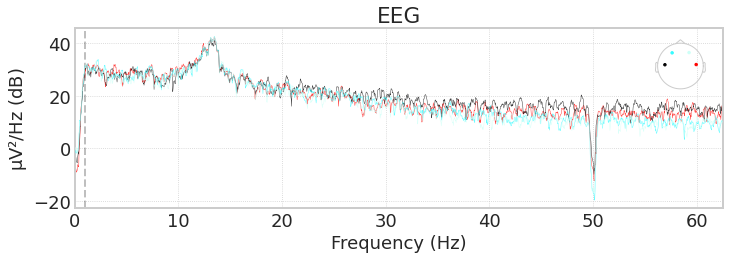

harold
    Using multitaper spectrum estimation with 7 DPSS windows


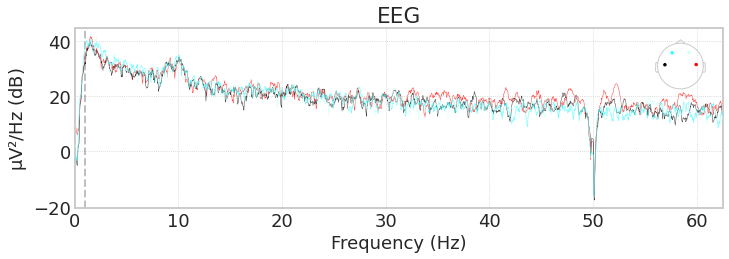

kant
    Using multitaper spectrum estimation with 7 DPSS windows


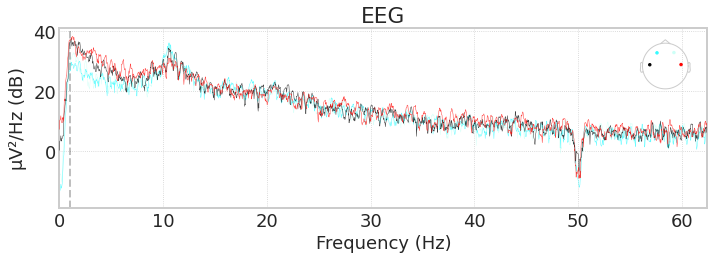

kao
    Using multitaper spectrum estimation with 7 DPSS windows


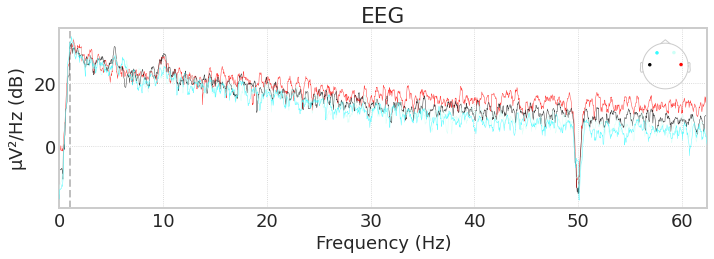

mu
    Using multitaper spectrum estimation with 7 DPSS windows


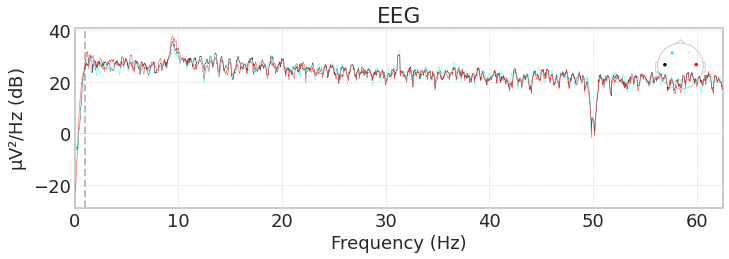

nisit
    Using multitaper spectrum estimation with 7 DPSS windows


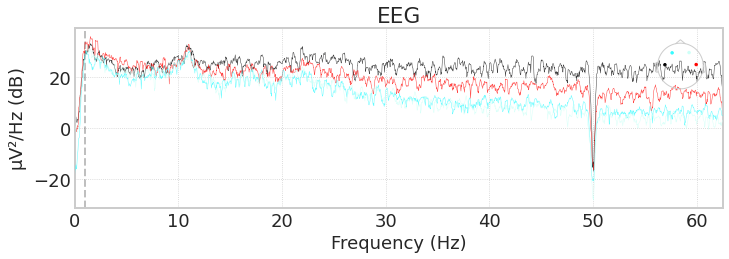

pla
    Using multitaper spectrum estimation with 7 DPSS windows


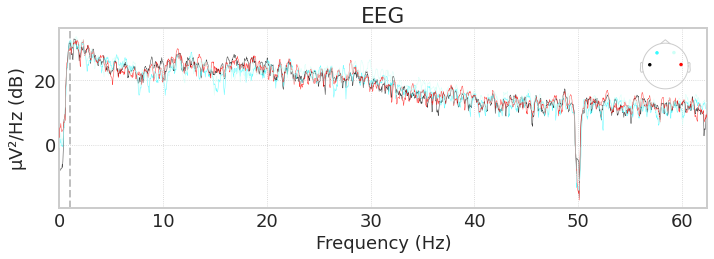

ploy
    Using multitaper spectrum estimation with 7 DPSS windows


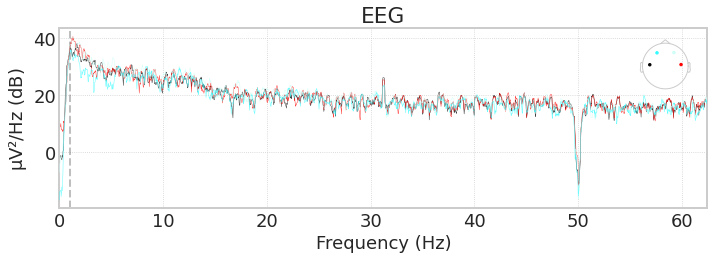

poon
    Using multitaper spectrum estimation with 7 DPSS windows


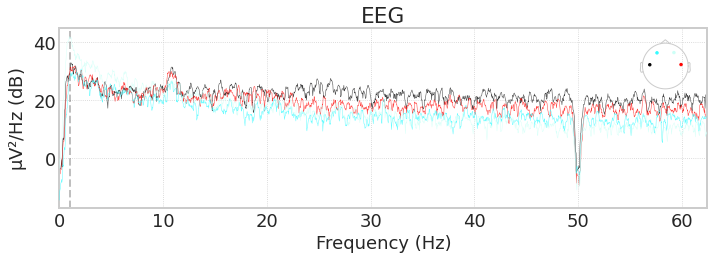

praewphan
    Using multitaper spectrum estimation with 7 DPSS windows


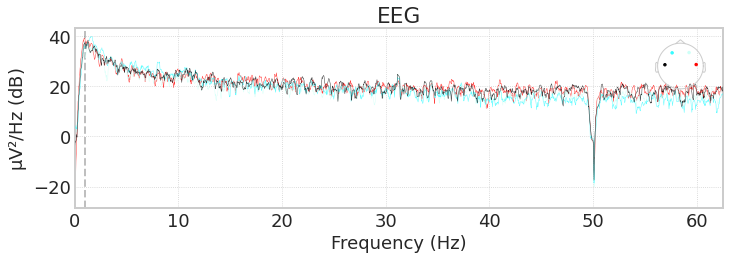

s
    Using multitaper spectrum estimation with 7 DPSS windows


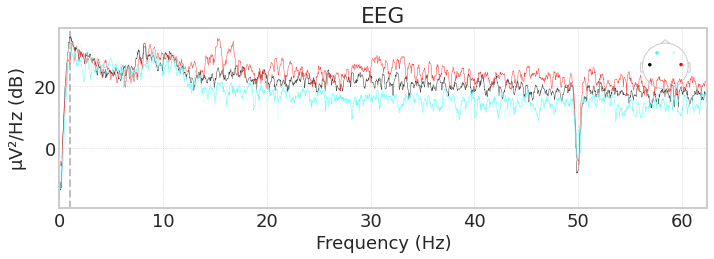

younten
    Using multitaper spectrum estimation with 7 DPSS windows


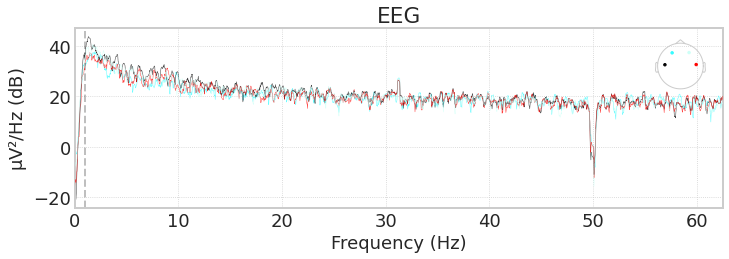

tor
    Using multitaper spectrum estimation with 7 DPSS windows


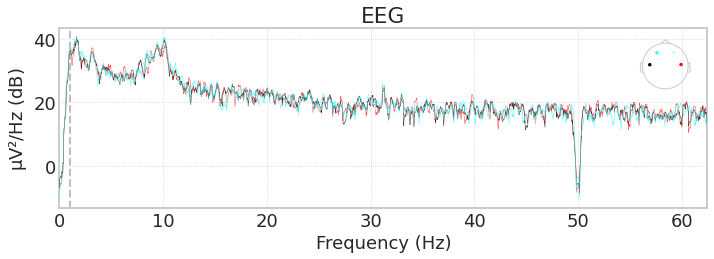

In [6]:
for name, info in PSS.items():
    raw = info['raw']
    raw.filter(l_freq=1,h_freq=None, method='iir', iir_params={'order':3.0, 'ftype':'butter'}, verbose=False) # Slow drift
    raw.notch_filter(freqs=[50])
    epochs = mne.Epochs(raw, np.array([[125*60*1, 0, 1]]), tmin=0, tmax=30, baseline=(0,30), verbose=False)
    print(name)
    a = epochs.plot_psd(picks=['F3','F4','T3','T4'])
    print("="*40)

In [7]:
def get_freq(PSS):
    # peak at info
    temp = PSS.popitem()
    PSS[temp[0]] = temp[1]
    raw = temp[1]['raw']
    epochs
    power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=True)
    return freq

freq = get_freq(PSS)
print(freq)

Effective window size : 1.000 (s)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]


In [8]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta'])
filter_list = [[1,3],[4,7],[8,12],[13,30],[30,43], [4,13], [13,17]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)
print(bands)

[array([1, 2, 3]) array([4, 5, 6, 7]) array([ 8,  9, 10, 11, 12])
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30])
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
 array([13, 14, 15, 16, 17])]


/tmp/ipykernel_7078/3256231302.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [9]:
# features = None
for name,info in PSS.items():
    raw = info['raw']
    feature = None
    slow, gamma = None, None
    a_f3, a_f4 = None, None
    a_t7, a_t8 = None, None
    b_f3, b_f4 = None, None
    b_t7, b_t8 = None, None
    epochs = mne.Epochs(raw, np.array([[125*60*1, 0, 1]]), tmin=0, tmax=30, baseline=(0,30), verbose=False)
    for index, band in enumerate(bands):
        power,freq = mne.time_frequency.psd_welch(epochs,n_fft=125, verbose=False)
        power = power.squeeze()
        power = 10 * np.log10(power)
        data = power[::,band].mean(axis=1).reshape(1,-1)
        # for asym
        if(band_names[index] == 'Alpha'):
            a_f3 = data[:,raw.ch_names.index('F3')]
            a_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            a_t7 = data[:,raw.ch_names.index('T3')]
            a_t8 = data[:,raw.ch_names.index('T4')]
        if(band_names[index] == 'Beta'):
            b_f3 = data[:,raw.ch_names.index('F3')]
            b_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            b_t7 = data[:,raw.ch_names.index('T3')]
            b_t8 = data[:,raw.ch_names.index('T4')]

        ####### Mean for visualization #######
        data = data.mean().reshape(1,-1)
        # for relative gamma
        if(band_names[index] == 'Slow'): slow = data
        if(band_names[index] == 'Gamma'): gamma = data

        if(type(feature) == type(None)): feature = data
        else: feature = np.concatenate([feature, data], axis=1)
    # print(feature.shape)
    # the eighth feature: relative gamma is slow/gamma
    relative_gamma = slow/gamma
    feature = np.concatenate([feature, relative_gamma], axis=1)
    # The asymetry
    alpha_frontal = ((a_f4 - a_f3) / (a_f4 + a_f3)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_frontal], axis=1)
    # alpha_temporal
    alpha_temporal = ((a_t8 - a_t7) / (a_t8 + a_t7)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_temporal], axis=1)
    # alpha_asymmetry
    alpha_asymmetry = alpha_frontal + alpha_temporal
    feature = np.concatenate([feature, alpha_asymmetry], axis=1)
    # beta_frontal
    beta_frontal = ((b_f4 - b_f3) / (b_f4 + b_f3)).reshape(1,-1)
    feature = np.concatenate([feature, beta_frontal], axis=1)
    # beta_temporal
    beta_temporal = ((b_t8 - b_t7) / (b_t8 + b_t7)).reshape(1,-1)
    feature = np.concatenate([feature, beta_temporal], axis=1)

    # print(slow/gamma)
    # print(feature.shape)
    # print(feature)
    info['feature'] = feature
    # if(type(features) == type(None)): features = feature
    # else: features = np.concatenate([features, feature], axis=0)
# print(features.shape)


In [10]:
# plt.plot(feature)
feature_names = list(band_names)
feature_names.append('Relative_Gamma')
feature_names.append('Alpha_Frontal')
feature_names.append('Alpha_Temporal')
feature_names.append('Alpha_Asymmetry')
feature_names.append('Beta_Frontal')
feature_names.append('Beta_Temporal')
feature_names = np.array(feature_names)
feature_names[[3,10]]
X_ori,y_ori = [], []
filtered_participants = []
filtered_scored = []
for index,(name,info) in enumerate(PSS.items()):
    # Neutral
    if(info['type'] == 1): continue
    # Non-Stress
    elif(info['type'] == 0):
        y_ori.append(0)
    # Stress
    elif(info['type'] == 2):
        y_ori.append(1)
    X_ori.append(info['feature'])
    filtered_participants.append(name)
    filtered_scored.append(info['score'])

In [11]:
def NormJa(data):
    for index, row in enumerate(data):
        min = row.min()
        max = row.max()
        mean = row.mean()
        row = (row - min) / (max - min)
        data[index] = row
        # print(row)
    return data

def StandardJa(data):
    data
    for index, row in enumerate(data):
        mean = row.mean()
        std = row.std()
        row = (row - mean) / std
        data[index] = row
        # print(row)
    return data

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
X,y = np.array(X_ori).squeeze(axis=1), np.array(y_ori)
# X = normalize(X.copy(), axis=0)
# X = NormJa(X.copy().T).T
X = StandardJa(X.copy().T).T
X_shuff,y_shuff = shuffle(X,y)
print(X.shape, y.shape)

param_grid = dict(kernel=['linear','poly','rbf', 'sigmoid'])#,'precomputed'])
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X, y)
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}")

model = SVC(kernel='rbf')
# model = GaussianNB()
model.fit(X_shuff, y_shuff)
ans = model.predict(X_shuff)
acc = sum(ans == y_shuff) / len(y_shuff)
cross = cross_val_score(model, X_shuff, y_shuff, cv=5)
print(acc, cross.mean(), cross)
print(ans)

(35, 13) (35,)
The best parameters are {'kernel': 'rbf'} with a score of 0.60
0.8285714285714286 0.5428571428571428 [0.42857143 0.42857143 0.57142857 0.85714286 0.42857143]
[0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1]


In [13]:
feature_names[7:]

array(['Relative_Gamma', 'Alpha_Frontal', 'Alpha_Temporal',
       'Alpha_Asymmetry', 'Beta_Frontal', 'Beta_Temporal'], dtype='<U15')

In [14]:
ans = model.predict(X)
acc = sum(ans == y) / len(y)
print(f"0: Non-Stress {type_count[0]}")
print(f"1: Stress {type_count[2]}")
print(f"Wrong\t|pred|label |Score |Name")
print("="*40)
for index,(i,j) in enumerate(zip(ans,y)):
    wrong = ""
    if(i != j):
        wrong = "X"
    print(f"{wrong}\t|{i}   |{j}     |{filtered_scored[index]}\t   |{filtered_participants[index]}")

0: Non-Stress 16
1: Stress 19
Wrong	|pred|label |Score |Name
	|1   |1     |25	   |fabby
	|1   |1     |25	   |bas
	|1   |1     |37	   |flm
X	|1   |0     |12	   |MJ
X	|0   |1     |28	   |new
	|0   |0     |15	   |nuclear
	|1   |1     |29	   |pang
	|0   |0     |9	   |prin
	|0   |0     |13	   |amp
	|0   |0     |9	   |beau
X	|1   |0     |16	   |dt
	|0   |0     |15	   |int
	|1   |1     |24	   |minkhant
	|1   |1     |27	   |yong
	|1   |1     |28	   |aui
	|1   |1     |25	   |bank
	|1   |1     |24	   |eiyu
	|0   |0     |13	   |job
	|1   |1     |25	   |kee
	|0   |0     |14	   |miiw
	|0   |0     |8	   |noey
	|0   |0     |13	   |shin
	|0   |0     |17	   |suyo
	|1   |1     |24	   |yee
	|1   |1     |24	   |bam
X	|1   |0     |17	   |beer
	|1   |1     |26	   |cedric
	|1   |1     |37	   |fahmai
	|1   |1     |27	   |gon
	|1   |1     |24	   |kao
X	|1   |0     |16	   |mu
X	|1   |0     |11	   |nisit
	|1   |1     |27	   |pla
	|1   |1     |27	   |ploy
	|0   |0     |16	   |praewphan
